# Policy Evaluation

A Policy is a mapping from state to action. 

Let us assume an environment with 7 states. 
State 0 and State 6 are terminating states. State 0 is a hole and yields a reward of 0. State 6 is a Goal with a reward of 1. 

Agent starts in state  3 and perform actions left (0) and right (1). 

Transition Probabilities are as follows

50% of the time action succeeds. 33.33% of the time agent doesnt move on an action. 16.66% of the time agent move in the opposite direction of action.

|H&nbsp;0|&nbsp;&nbsp;1&nbsp;&nbsp;|&nbsp;&nbsp;2&nbsp;&nbsp;|&nbsp;&nbsp;S&nbsp;3&nbsp;|&nbsp;&nbsp;4&nbsp;&nbsp;|&nbsp;&nbsp;5&nbsp;&nbsp;|&nbsp;&nbsp;G&nbsp;6&nbsp;|

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
np.set_printoptions(formatter={'float': '{: 0.4f}'.format})

In [2]:
# Environment modeled as dict of dictionaries
# Tuples are encoded as [Probability, next state, reward, terminal state]
class BSW:
    def __init__(self):
        self.state = None
        self.render_once = False
        
    def reset(self, start_state=3):
        self.bw_env = {
            0: {
                0: [1.0, 0, 0.0, True],
                1: [1.0, 0, 0.0, True],
            },
            1: {
                0: [1.0, 0, 0.0, False],
                1: [1.0, 2, 0.0, False],
            },
            2: {
                0: [1.0, 1, 0.0, False],
                1: [1.0, 3, 0.0, False],
            },
            3: {
                0: [1.0, 2, 0.0, False],
                1: [1.0, 4, 0.0, False],
            },
            4: {
                0: [1.0, 3, 0.0, False],
                1: [1.0, 5, 0.0, False],
            },
            5: {
                0: [1.0, 4, 0.0, False],
                1: [1.0, 6, 1.0, True],
            },
            6: {
                0: [1.0, 6, 0.0, True],
                1: [1.0, 6, 0.0, True],
            }
            
        }
        self.bsw_env = {
            0: {
                0:[(1.0, 0, 0.0, True)],
                1:[(1.0, 0, 0.0, True)]
            },
            1: {
                0:[(0.50, 0, 0.0, False),
                   (0.34, 1, 0.0, False),
                   (0.16, 2, 0.0, False)],
                1:[(0.50, 2, 0.0, False),
                   (0.34, 1, 0.0, False),
                   (0.16, 0, 0.0, False)],
             },
            2: {
                0:[(0.50, 1, 0.0, False),
                   (0.34, 2, 0.0, False),
                   (0.16, 3, 0.0, False)],
                1:[(0.50, 3, 0.0, False),
                   (0.34, 2, 0.0, False),
                   (0.16, 1, 0.0, False)],
             },
            3: {
                0:[(0.50, 2, 0.0, False),
                   (0.34, 3, 0.0, False),
                   (0.16, 4, 0.0, False)],
                1:[(0.50, 4, 0.0, False),
                   (0.34, 3, 0.0, False),
                   (0.16, 2, 0.0, False)],
             },
            4: {
                0:[(0.50, 3, 0.0, False),
                   (0.34, 4, 0.0, False),
                   (0.16, 5, 0.0, False)],
                1:[(0.50, 5, 0.0, False),
                   (0.34, 4, 0.0, False),
                   (0.16, 3, 0.0, False)],
             },
            5: {
                0:[(0.50, 4, 0.0, False),
                   (0.34, 5, 0.0, False),
                   (0.16, 6, 1.0, True)],
                1:[(0.50, 6, 1.0, True),
                   (0.34, 5, 0.0, False),
                   (0.16, 4, 0.0, False)],
             },
            6: {
                0:[(1.0, 6, 0.0, True)],
                1:[(1.0, 6, 0.0, True)]
            }
        }
        self.state = start_state
        reward = [1.0 if self.state == 6 else 0.0]
        done = [True if (self.state == 6 or self.state==0) else False]
        return self.state, reward[0], done[0]
        
    def step(self, action):
        # Get tuple of next possible states
        transition_tuples = self.bsw_env[self.state][action]
        # Separate tuple into prob, next states, rewards and done
        trans_probs = [i[0] for i in transition_tuples]
        nps = [i[1] for i in transition_tuples]
        rewards = [i[2] for i in transition_tuples]
        done_vals = [i[3] for i in transition_tuples]
        # Select next state index based on trans_probs
        ns_idx = np.random.choice([i for i in range(len(transition_tuples))], p=trans_probs)
        # Set state of environment
        self.state = nps[ns_idx]
        return (self.state, rewards[ns_idx], done_vals[ns_idx])
    
    def render(self, print_state_names=False):
        if print_state_names:
            print("|  H-0  |  1  |  2  |  3  |  4  |  5  |  G-6  |")
        for i in range(7):
            str_to_print = "|  "
            if i == 0:
                str_to_print += "  "
            if i == self.state:
                str_to_print += "A"
                str_to_print += "  "
            else:
                str_to_print += "   "
            if i == 6:
                str_to_print += "  |"
            print(str_to_print, end='')
        print("")
            
            

[ 0.0000  0.0023  0.0094  0.0317  0.1014  0.3193  0.0000]


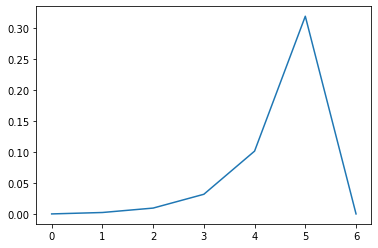

In [3]:
env = BSW()
state, reward, done = env.reset(start_state=3)
# Policy Evaluation
num_episodes = 20
action = 0

def svf(env, action, gamma=1.0, theta=1e-10):
    P = env.bsw_env
    prev_vfunc = np.zeros(len(P))
    while True:
        vfunc = np.zeros(len(P))
        for s in range(len(P)):
            for prob, ns, reward, done in P[s][action]:
                vfunc[s] += prob * (reward + (gamma * prev_vfunc[ns] * (not done)))
        if np.max(np.abs(prev_vfunc - vfunc)) < theta:
            break
        prev_vfunc = vfunc.copy()  
    return vfunc

v = svf(env, action)
print(v)
_ = plt.plot(v)

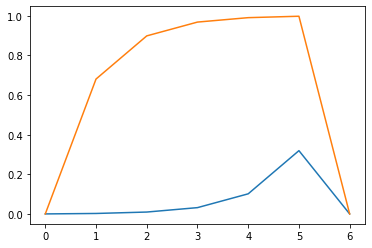

In [4]:
def avf(env, gamma=1.0, theta=1e-10):
    actions = [0, 1]
    P = env.bsw_env
    prev_avfunc = np.zeros(shape=(len(actions), len(P)))
    while True:
        avfunc = np.zeros(shape=(len(actions), len(P)))
        for action in actions:
            for state in range(len(P)):
                for prob, ns, reward, done in P[state][action]:
                    avfunc[action][state] += prob * (reward + gamma * prev_avfunc[action][ns]\
                                                     * (not done))
        if np.max(np.abs(prev_avfunc - avfunc)) < theta:
            break
        prev_avfunc = avfunc.copy()
    return avfunc
avfunc = avf(env)
plt.plot(avfunc[0])
plt.plot(avfunc[1])

In [5]:
print(avfunc[0] - v)
print(avfunc[1] - v)

[ 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000]
[ 0.0000  0.6784  0.8891  0.9365  0.8891  0.6784  0.0000]
